In [1]:
%load_ext autoreload
%autoreload 2

from readers import *
from models import *
from datalib import *
import config.config_create_trajectory as config

from decimal import Decimal, ROUND_DOWN, ROUND_UP
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
import time as t
%matplotlib notebook

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
start_time = t.time()
print("Reading demonstration data")

position_datasets = []
velocity_datasets = []
orientation_datasets = []

for demo in config.demos:
    print(f'Reading demonstration file {demo}')
    franka_reader = FrankaStateReader(demo)

    position_dataset = PositionDataSet()
    orientation_dataset = PositionDataSet()
    velocity_dataset = PositionDataSet()

    for i in range(len(franka_reader.msgs)):
        dp = franka_reader.next_datapoint()
        time = dp.time
        franka_state = dp.value

        position_dataset.append(PositionDataPoint(time, franka_state.position))
        velocity_dataset.append(PositionDataPoint(time, franka_state.velocity))
        orientation_dataset.append(PositionDataPoint(time, franka_state.euler_angles))
        
    position_dataset.align_time()
    velocity_dataset.align_time()
    orientation_dataset.align_time()

    position_datasets.append(position_dataset)
    velocity_datasets.append(velocity_dataset)
    orientation_datasets.append(orientation_dataset)

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Reading demonstration data
Reading demonstration file data/demo13.bag
Reading demonstration file data/demo14.bag
Reading demonstration file data/demo15.bag
Reading demonstration file data/demo16.bag
Reading demonstration file data/demo17.bag
--- 12.60306429862976 seconds ---
Done


In [3]:
start_time = t.time()
print("Initializing datasets handle")

impact_intervals = []
for i in range(len(config.impact_intervals)):
    delayed_demo_impact_intervals = config.impact_intervals[i]
    impact_detection_delays = config.impact_detection_delays[i]
        
    demo_impact_intervals = []
    for delayed_impact_interval in delayed_demo_impact_intervals:
        impact_interval = ()
        for j in range(len(delayed_impact_interval)):
            impact_interval += (delayed_impact_interval[j] - impact_detection_delays[j],)
        demo_impact_intervals.append(impact_interval)
    impact_intervals.append(demo_impact_intervals)

datasets_handle = DataSetsHandle(position_datasets, velocity_datasets, orientation_datasets, impact_intervals)

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Initializing datasets handle
--- 3.5991628170013428 seconds ---
Done


In [4]:
start_time = t.time()
print("Extending demonstration data")

datasets_handle.align_position_data(trim=True)
datasets_handle.extend_position_data(config.position_extender)
datasets_handle.align_orientation_data(trim=True)
datasets_handle.extend_orientation_data(config.orientation_extender)

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Extending demonstration data
--- 0.14694786071777344 seconds ---
Done


In [5]:
start_time = t.time()
print("Creating ProMPs")

print("Creating position ProMPs")
position_promps = datasets_handle.create_position_promps(config.rbf_width, config.rbfs_per_second)
print("Position ProMPs created")

print("Creating orientation ProMPs")
orientation_promps = datasets_handle.create_orientation_promps(config.rbf_width, config.rbfs_per_second)
print("Orientation ProMPs created")

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Creating ProMPs
Creating position ProMPs
Position ProMPs created
Creating orientation ProMPs
Orientation ProMPs created
--- 12.781345129013062 seconds ---
Done


In [6]:
start_time = t.time()
print("Saving ProMPs to file")

json_object = dict()
json_object['rotation_matrix'] = datasets_handle.rotation_matrix.tolist()
json_object['phases'] = []
for phase in range(datasets_handle.n_phases):
    pos_promp_dicts = []
    or_promp_dicts = []
    for i in range(3):
        pos_promp_dicts.append(position_promps[phase].value[i].to_dict())
        or_promp_dicts.append(orientation_promps[phase].value[i].to_dict())
    phase_promps = dict()
    phase_promps['position_promps'] = pos_promp_dicts
    phase_promps['orientation_promps'] = or_promp_dicts
    json_object['phases'].append(phase_promps)

with open(config.output_file, 'w', encoding='utf-8') as f:
    json.dump(json_object, f, ensure_ascii=False, indent=4)

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Saving ProMPs to file
--- 0.19895172119140625 seconds ---
Done


In [7]:
def round_up(number, step_size):
    return float(Decimal(number).quantize(Decimal(str(step_size)), ROUND_UP))

def round_down(number, step_size):
    return float(Decimal(number).quantize(Decimal(str(step_size)), ROUND_DOWN))

In [8]:
start_time = t.time()
print("Evaluating ProMPs")

# Evaluate ProMPs
position_evaluated_data = []
velocity_evaluated_data = []
orientation_evaluated_data = []

for phase in range(datasets_handle.n_phases):
    position_evaluated_data.append(PositionDataSet())
    velocity_evaluated_data.append(PositionDataSet())
    orientation_evaluated_data.append(PositionDataSet())

    t_start = round_up(position_promps[phase][0].value.get_extended_start_end()[0], config.step_size)
    t_end = round_down(position_promps[phase][0].value.get_extended_start_end()[-1], config.step_size)
    timerange = np.arange(t_start, t_end, config.step_size).tolist()
    
    for time in timerange:

        # Via points for phase
        via_points = []
        for i in range(len(config.via_points)):
            via_points.append(DataSet())
            for via_point in via_points[i]:
                if via_point.time >= t_start and via_point.time <= t_end:
                    via_points[i].append(via_point)

        # position, velocity, orientation
        position_evaluated = []
        velocity_evaluated = []
        orientation_evaluated = []
        
        for j in range(3):
            position_evaluated.append(position_promps[phase][j].value.evaluate(time, via_points=via_points[j]))
            velocity_evaluated.append(position_promps[phase][j].value.evaluate(time, derivative=1, via_points=via_points[j]))
            orientation_evaluated.append(orientation_promps[phase][j].value.evaluate(time, via_points=via_points[j+3]))
        
        orientation_evaluated = Rotation.from_matrix(datasets_handle.rotation_matrix.T.dot(Rotation.from_euler('xyz',orientation_evaluated).as_matrix())).as_euler('xyz').tolist()
        
        position_evaluated_data[phase].append(PositionDataPoint(time, position_evaluated))
        velocity_evaluated_data[phase].append(PositionDataPoint(time, velocity_evaluated))
        orientation_evaluated_data[phase].append(PositionDataPoint(time, orientation_evaluated))
        
print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Evaluating ProMPs
--- 18.70953392982483 seconds ---
Done


<IPython.core.display.Javascript object>


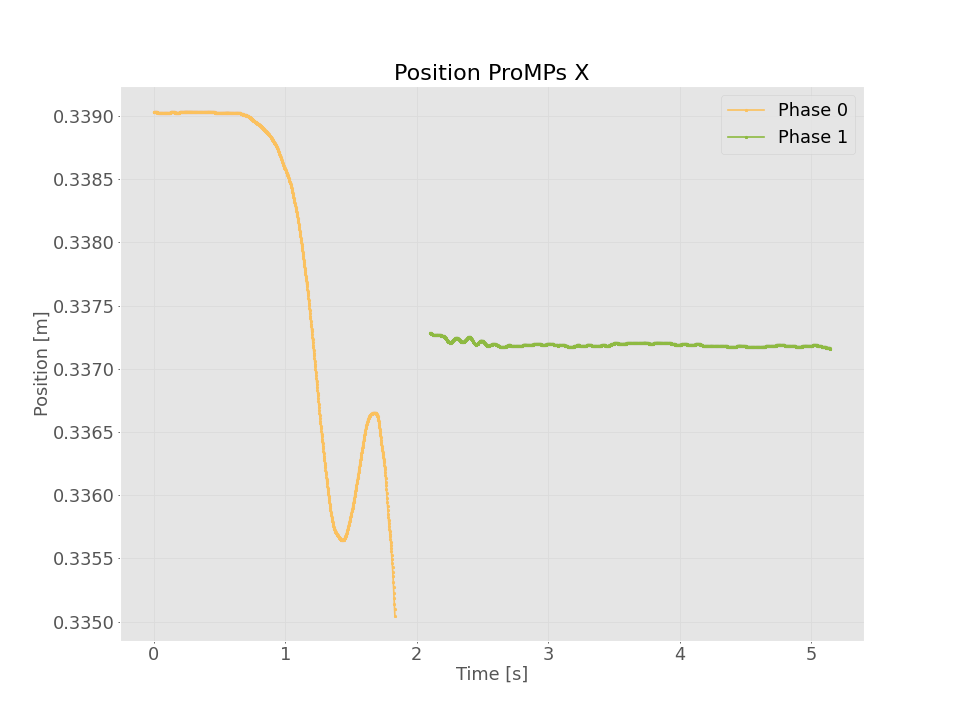

<IPython.core.display.Javascript object>


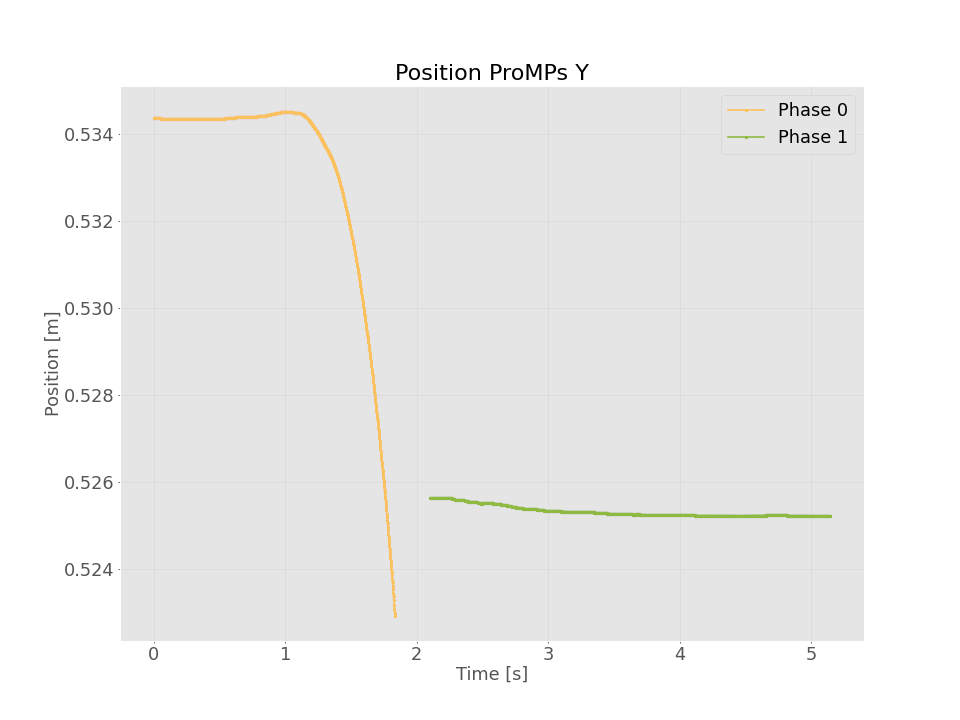

<IPython.core.display.Javascript object>


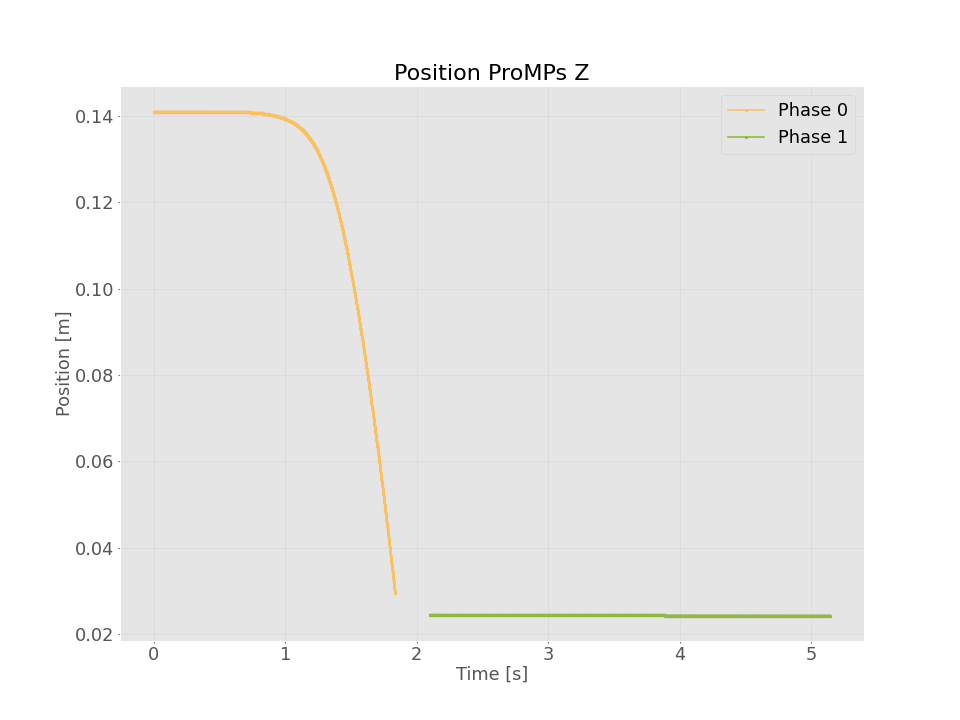

In [9]:
# Plot position data
for j in range(3):
    plt.figure(figsize=config.figsize,dpi=config.dpi)
    for phase in range(len(position_evaluated_data)):
        data = position_evaluated_data[phase].get_index(j)
        plt.rcParams['xtick.labelsize'] = config.fontsize2
        plt.rcParams['ytick.labelsize'] = config.fontsize2
        plt.plot(data.time, data.value,'C' + str(phase+4) + '-*',linewidth=config.linewidth, markersize=config.markersize3,label='Phase ' + str(phase))
    plt.legend(fontsize=config.fontsize2)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Position [m]',fontsize=config.fontsize2)
    plt.title('Position ProMPs ' + config.variable_labels[j],fontsize=config.fontsize1)

<IPython.core.display.Javascript object>


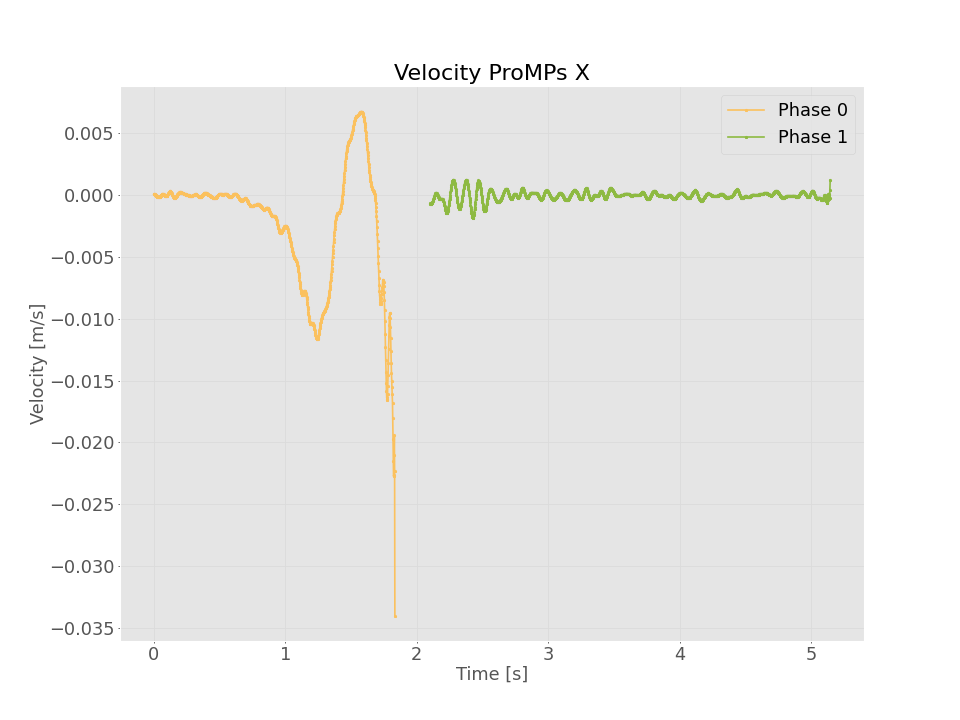

<IPython.core.display.Javascript object>


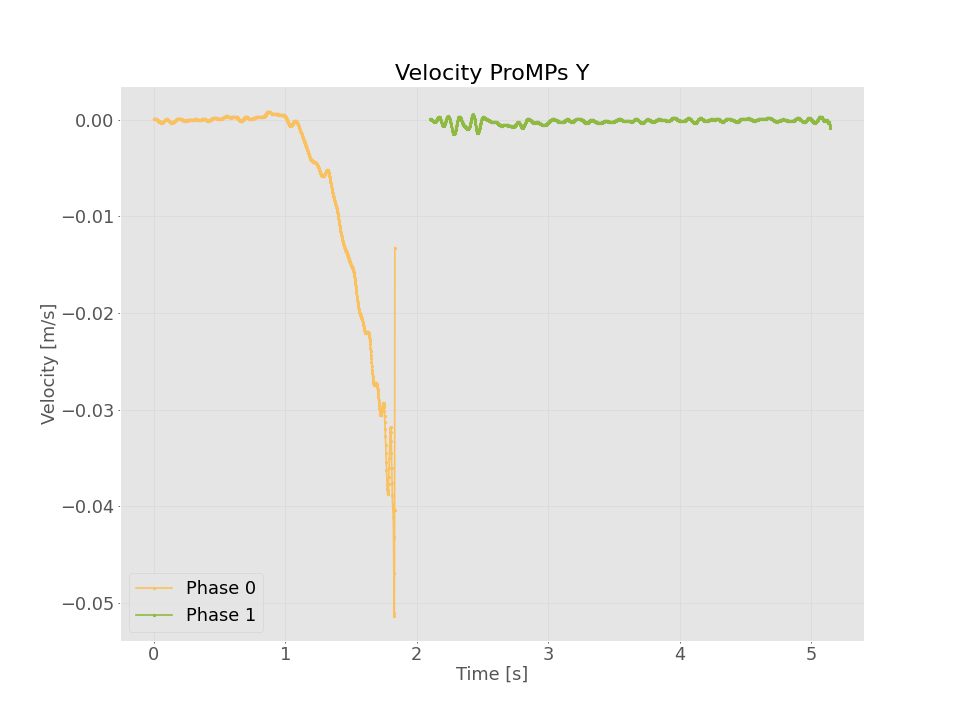

<IPython.core.display.Javascript object>


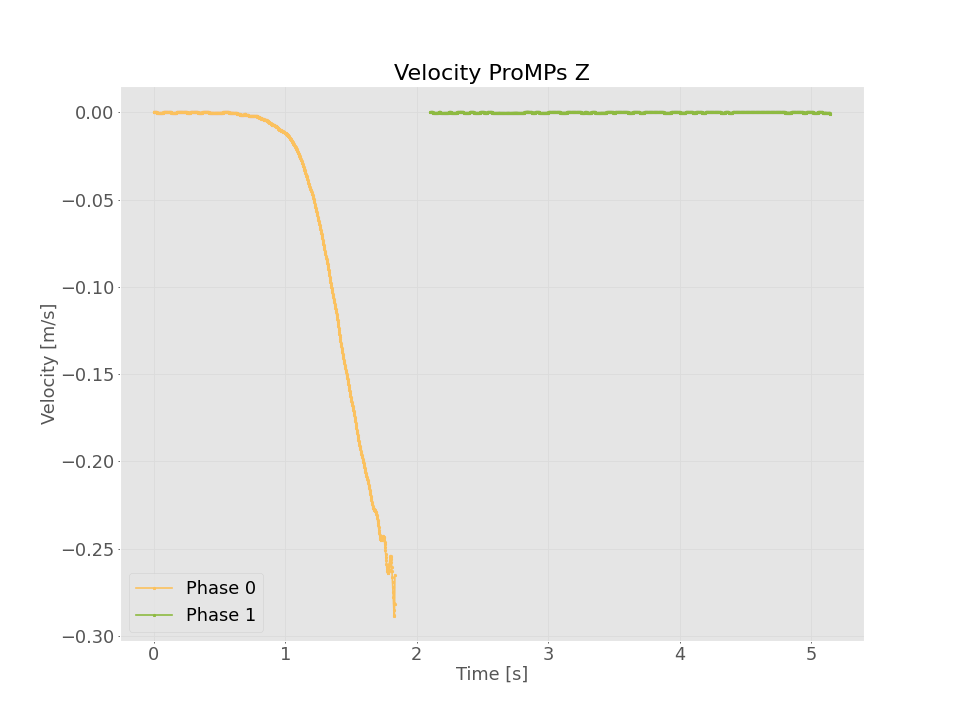

In [10]:
# Plot velocity data
for j in range(3):
    plt.figure(figsize=config.figsize,dpi=config.dpi)
    for phase in range(len(position_evaluated_data)):
        data = velocity_evaluated_data[phase].get_index(j)
        plt.rcParams['xtick.labelsize'] = config.fontsize2
        plt.rcParams['ytick.labelsize'] = config.fontsize2
        plt.plot(data.time, data.value,'C' + str(phase+4) + '-*',linewidth=config.linewidth, markersize=config.markersize3,label='Phase ' + str(phase))
    plt.legend(fontsize=config.fontsize2)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Velocity [m/s]',fontsize=config.fontsize2)
    plt.title('Velocity ProMPs ' + config.variable_labels[j],fontsize=config.fontsize1)

<IPython.core.display.Javascript object>


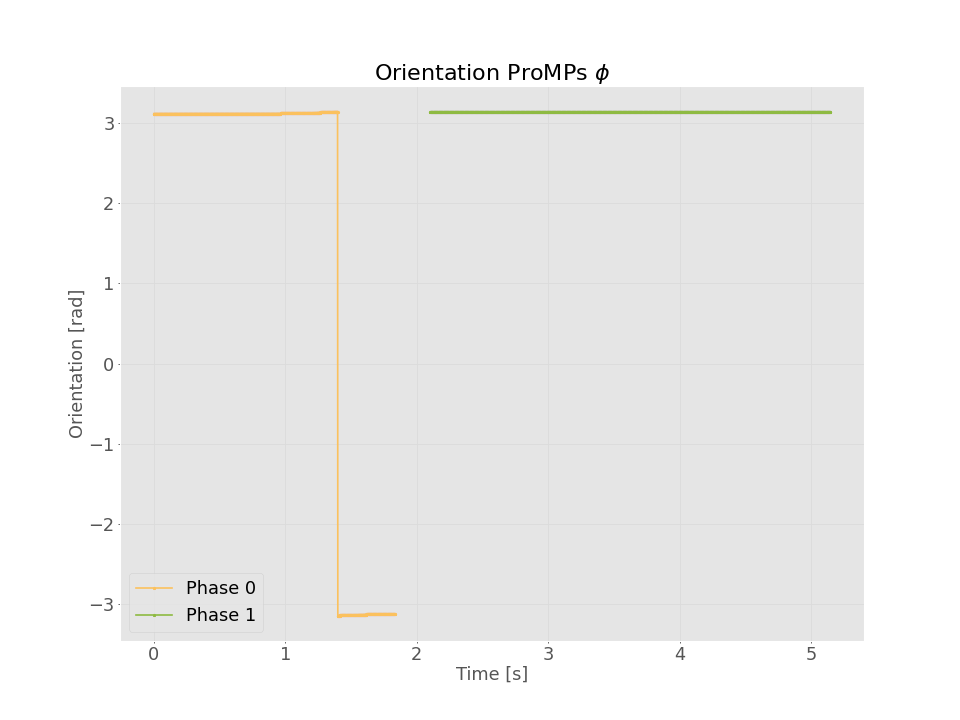

<IPython.core.display.Javascript object>


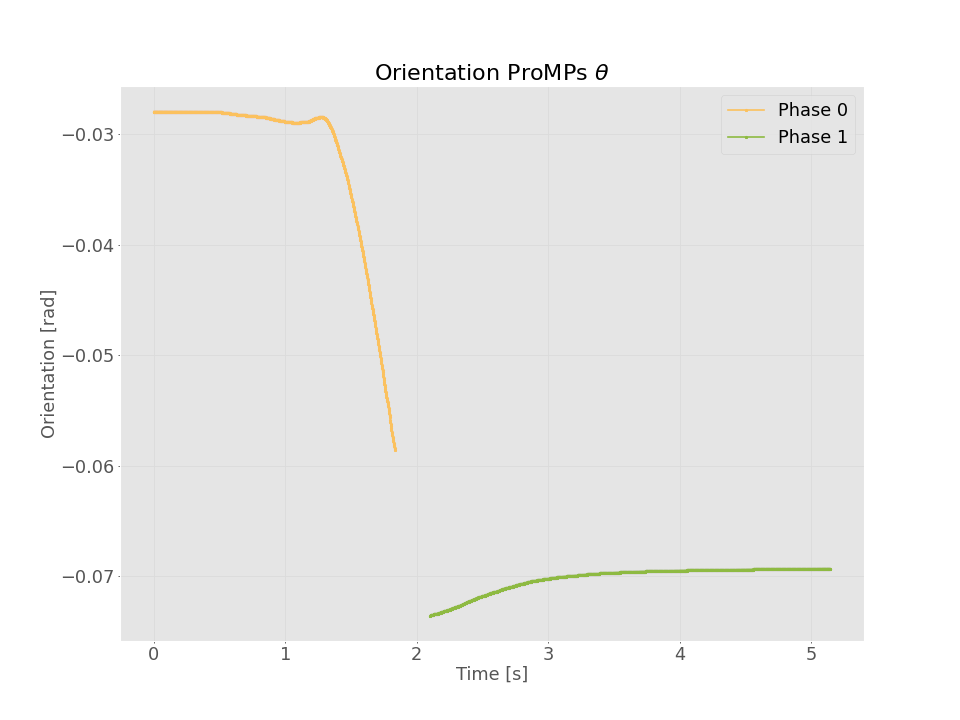

<IPython.core.display.Javascript object>


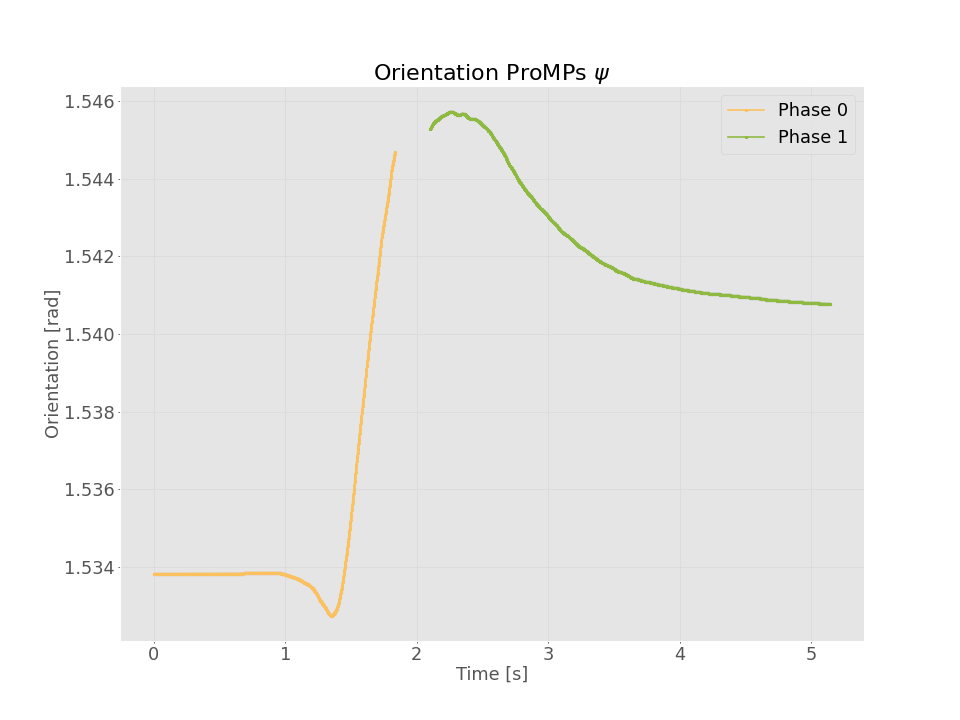

In [11]:
# Plot orientation data
for j in range(3):
    plt.figure(figsize=config.figsize,dpi=config.dpi)
    for phase in range(len(orientation_evaluated_data)):
        data = orientation_evaluated_data[phase].get_index(j)
        plt.rcParams['xtick.labelsize'] = config.fontsize2
        plt.rcParams['ytick.labelsize'] = config.fontsize2
        plt.plot(data.time, data.value,'C' + str(phase+4) + '-*',linewidth=config.linewidth, markersize=config.markersize3,label='Phase ' + str(phase))
    plt.legend(fontsize=config.fontsize2)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Orientation [rad]',fontsize=config.fontsize2)
    plt.title('Orientation ProMPs ' + config.variable_labels[j+3],fontsize=config.fontsize1)

In [12]:
start_time = t.time()
print("Preparing data for phase comparison")

position_phase_data = []
velocity_phase_data = []
orientation_phase_data = []

for phase in range(datasets_handle.n_phases):
    
    position_phase_data.append([])
    velocity_phase_data.append([])
    orientation_phase_data.append([])
    
    for trajectory_handle in datasets_handle.position_trajectory_handles:
        data = trajectory_handle.phase_data[phase]
        position_phase_data[phase].append(data.get_index(0).copy())
        velocity_phase_data[phase].append(data.get_index(1).copy())
    
    for trajectory_handle in datasets_handle.orientation_trajectory_handles:
        data = trajectory_handle.phase_data[phase]
        orientation_phase_data[phase].append(data.get_index(0).copy())
        
    for i in range(len(position_phase_data[phase])):
        time_shift = position_promps[phase][0].value.time_shift
        position_phase_data[phase][i].align_time(position_phase_data[phase][i][0].time + time_shift)
        velocity_phase_data[phase][i].align_time(velocity_phase_data[phase][i][0].time + time_shift)
        orientation_phase_data[phase][i].align_time(orientation_phase_data[phase][i][0].time + time_shift)
        
    for i in range(len(orientation_phase_data[phase])):
        for j in range(len(orientation_phase_data[phase][i])):
            orientation_phase_data[phase][i][j].value = Rotation.from_matrix(datasets_handle.rotation_matrix.T.dot(Rotation.from_euler('xyz',orientation_phase_data[phase][i][j].value).as_matrix())).as_euler('xyz').tolist()
        
print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Preparing data for phase comparison
--- 3.0741264820098877 seconds ---
Done


<IPython.core.display.Javascript object>


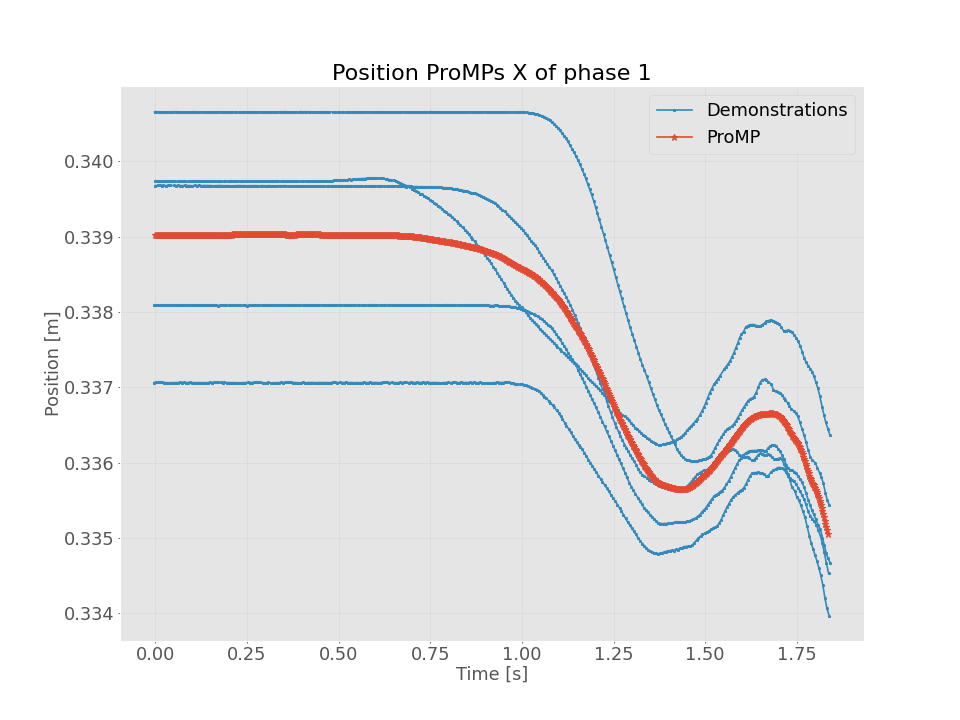

<IPython.core.display.Javascript object>


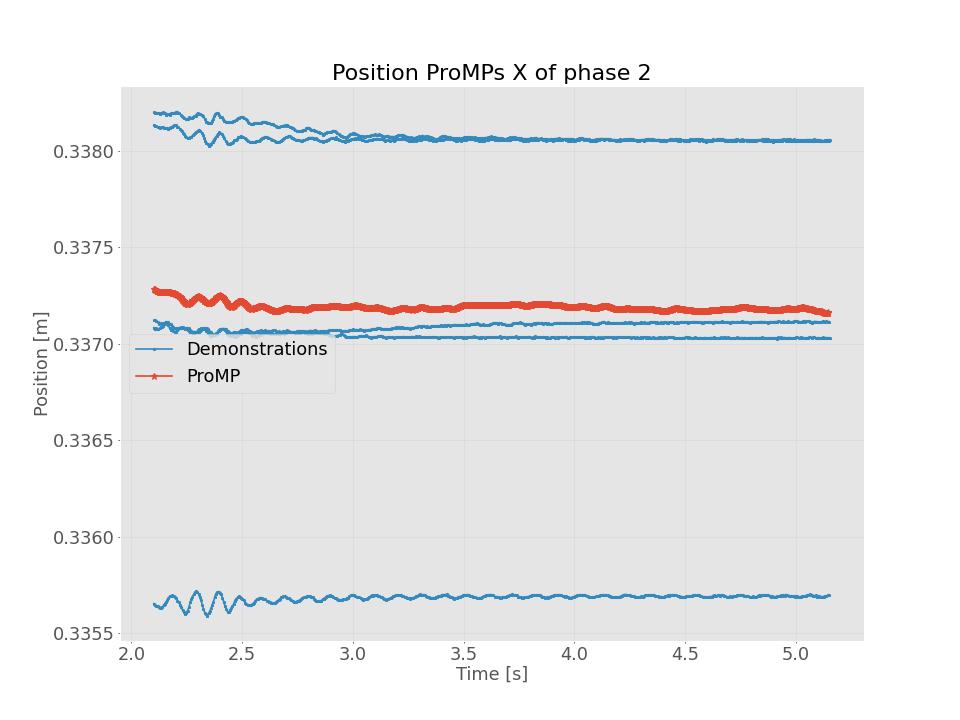

<IPython.core.display.Javascript object>


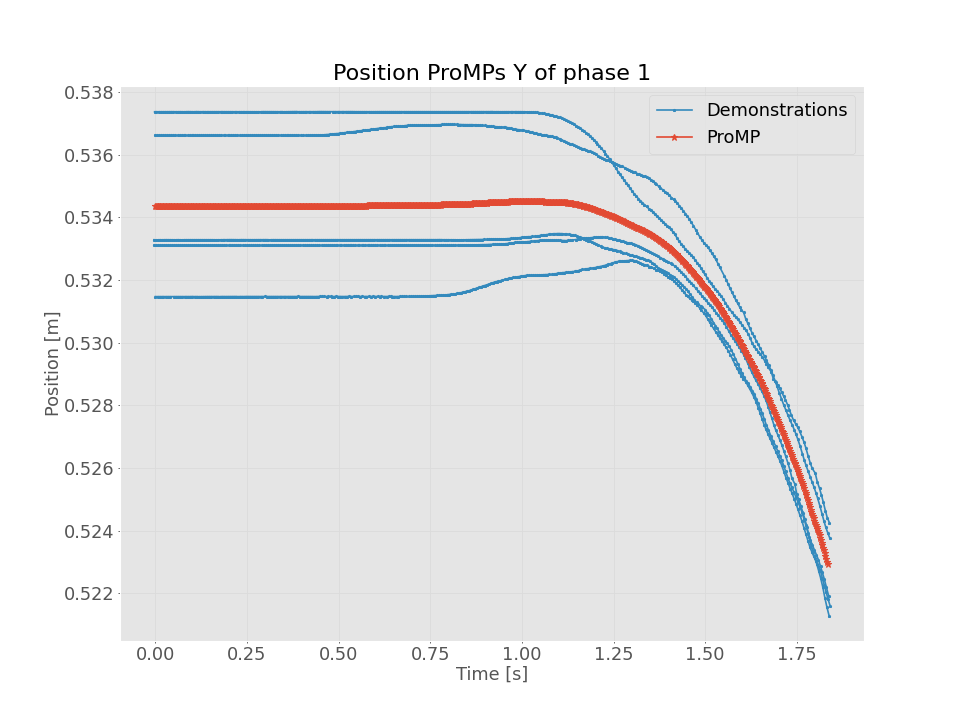

<IPython.core.display.Javascript object>


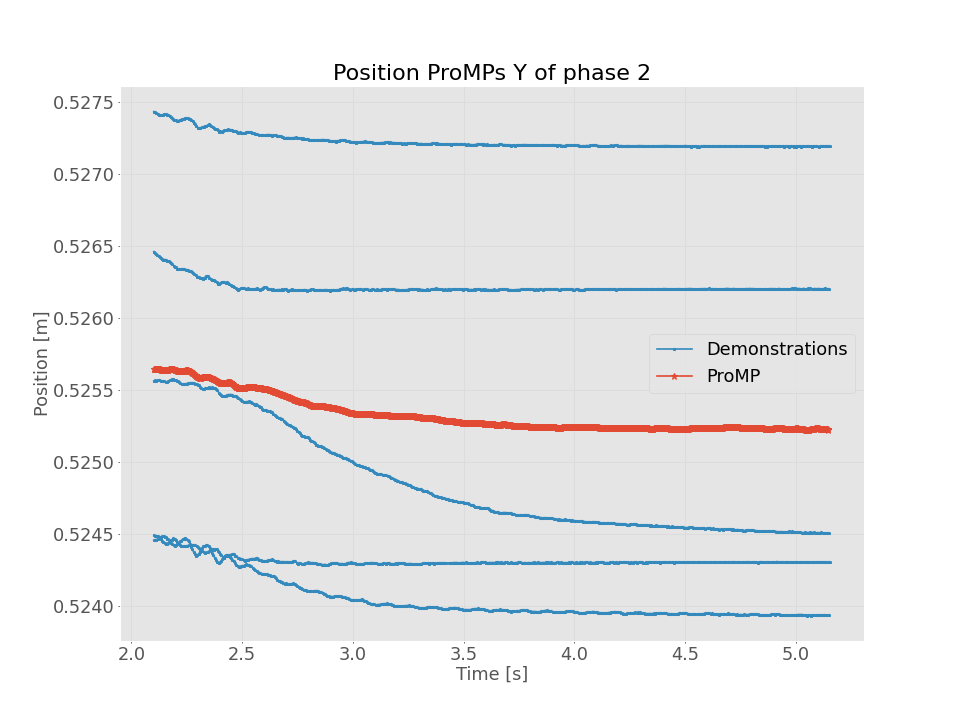

<IPython.core.display.Javascript object>


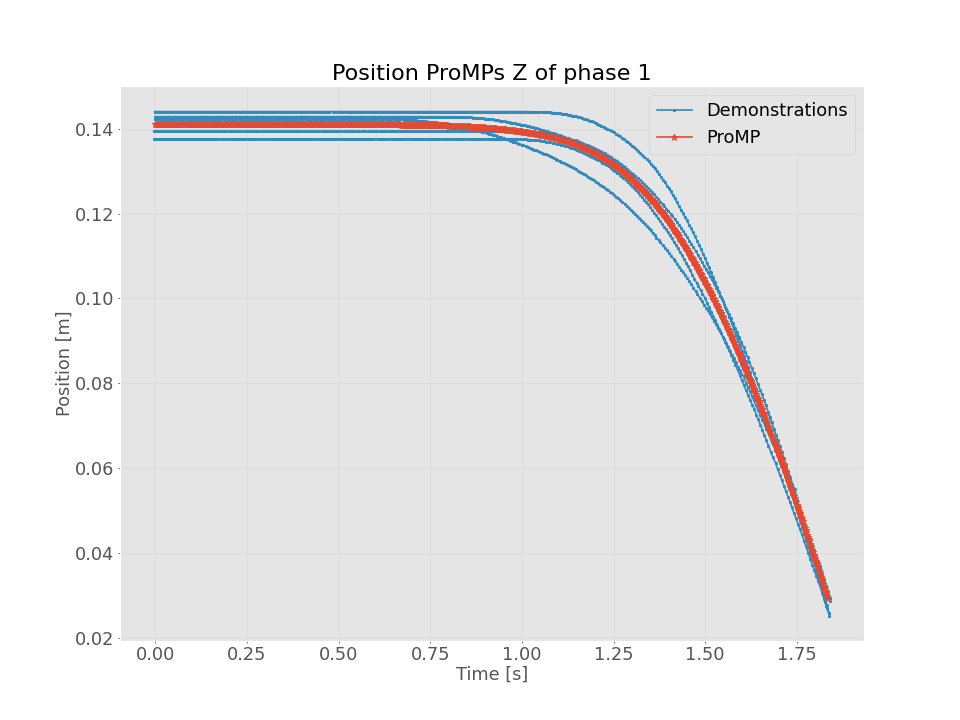

<IPython.core.display.Javascript object>


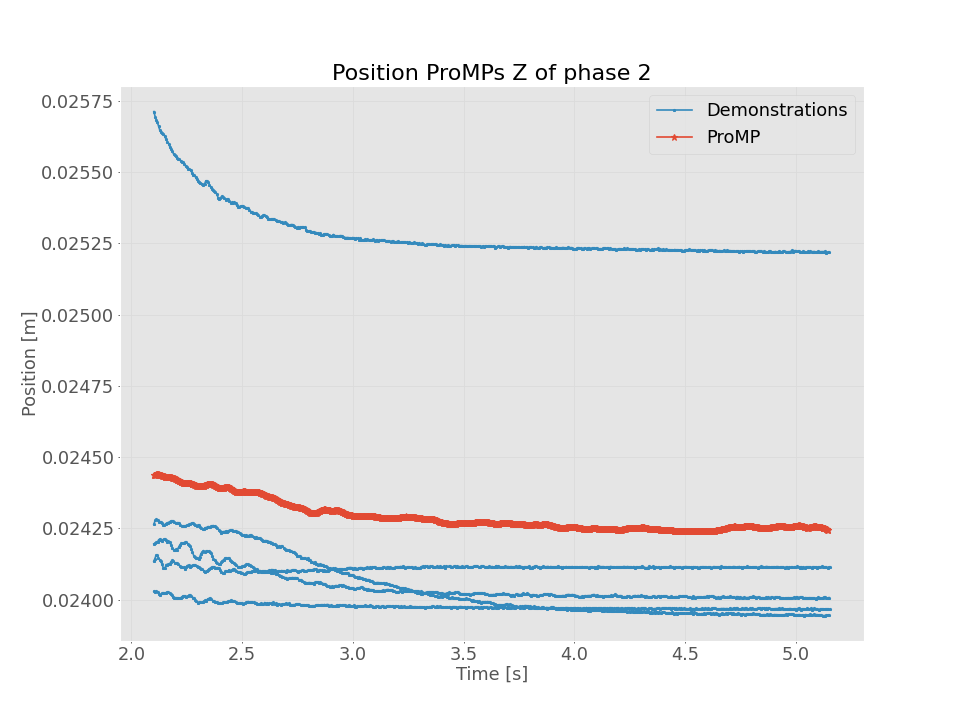

In [13]:
# Plot position data per phase
for j in range(3):
    for phase in range(len(position_evaluated_data)):
        plt.figure(figsize=config.figsize,dpi=config.dpi)
        plt.rcParams['xtick.labelsize'] = config.fontsize2
        plt.rcParams['ytick.labelsize'] = config.fontsize2
        
        for i in range(len(position_phase_data[phase])):
            data = position_phase_data[phase][i].get_index(j)
            plt.plot(data.time, data.value,'C1-*',linewidth=config.linewidth, markersize=config.markersize3,label=f'Demonstrations')
        
        data = position_evaluated_data[phase].get_index(j)
        plt.plot(data.time, data.value,'C0-*',linewidth=config.linewidth, markersize=config.markersize2,label='ProMP')
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
        plt.xlabel('Time [s]',fontsize=config.fontsize2)
        plt.ylabel('Position [m]',fontsize=config.fontsize2)
        plt.title(f'Position ProMPs {config.variable_labels[j]} of phase {phase+1}',fontsize=config.fontsize1)

<IPython.core.display.Javascript object>


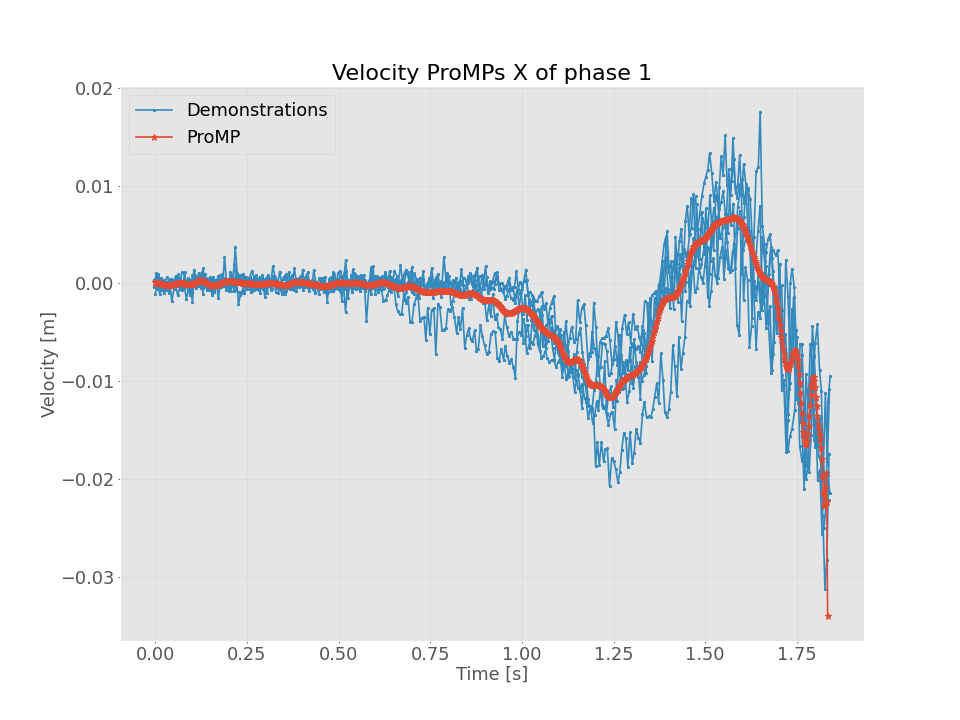

<IPython.core.display.Javascript object>


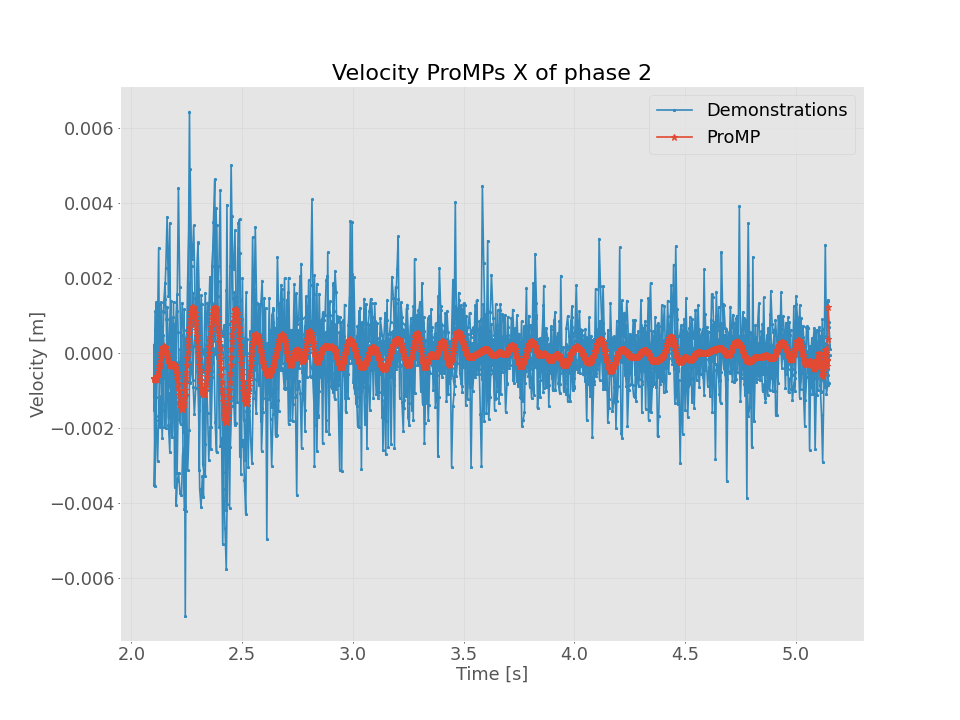

<IPython.core.display.Javascript object>


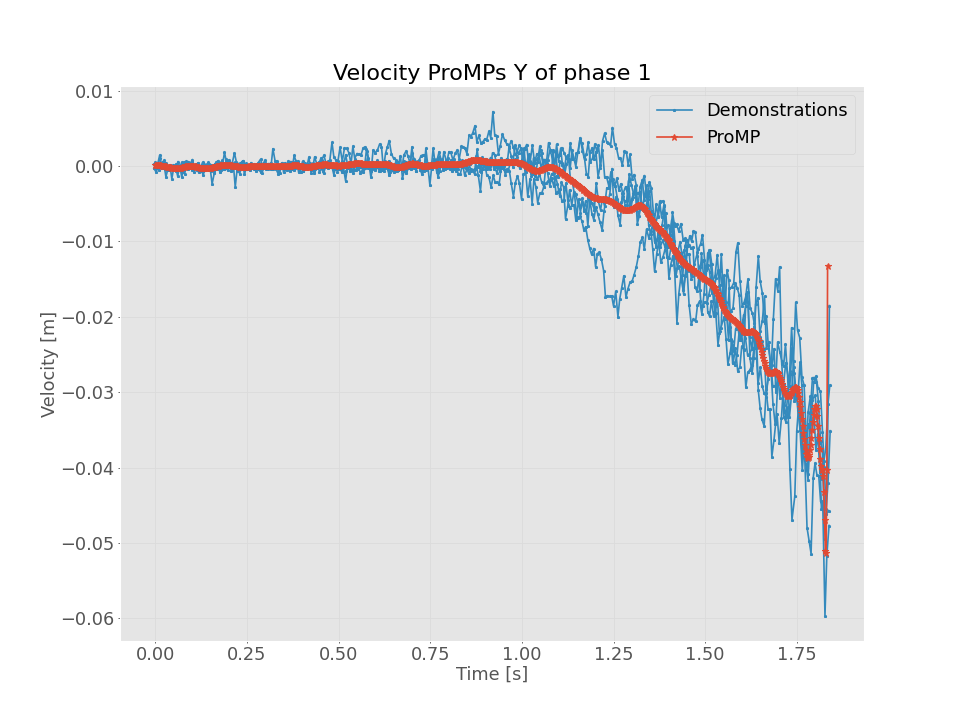

<IPython.core.display.Javascript object>


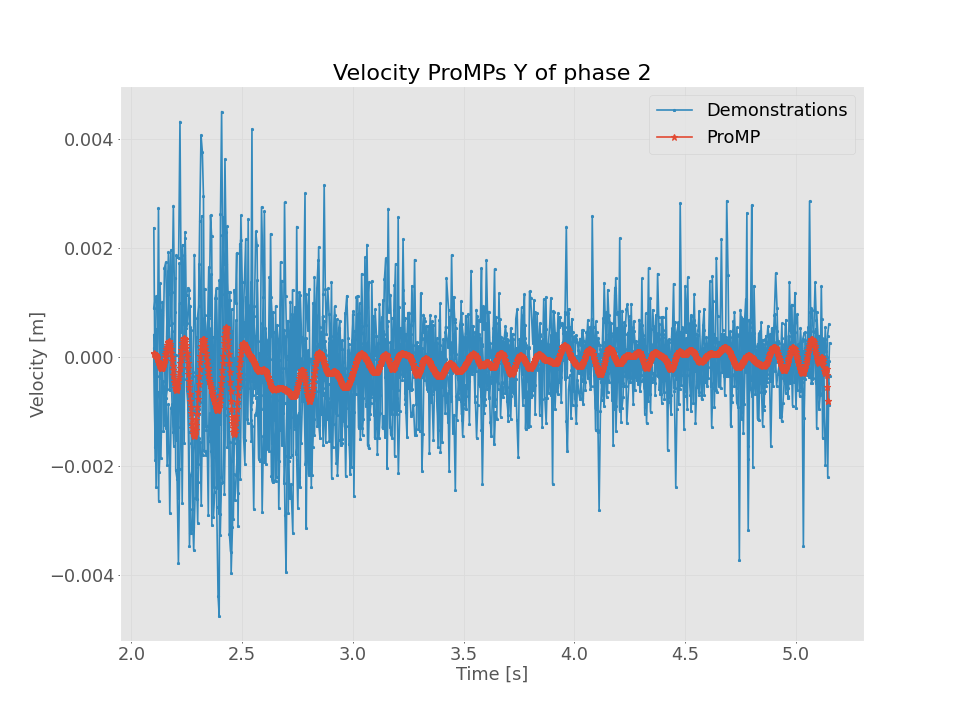

<IPython.core.display.Javascript object>


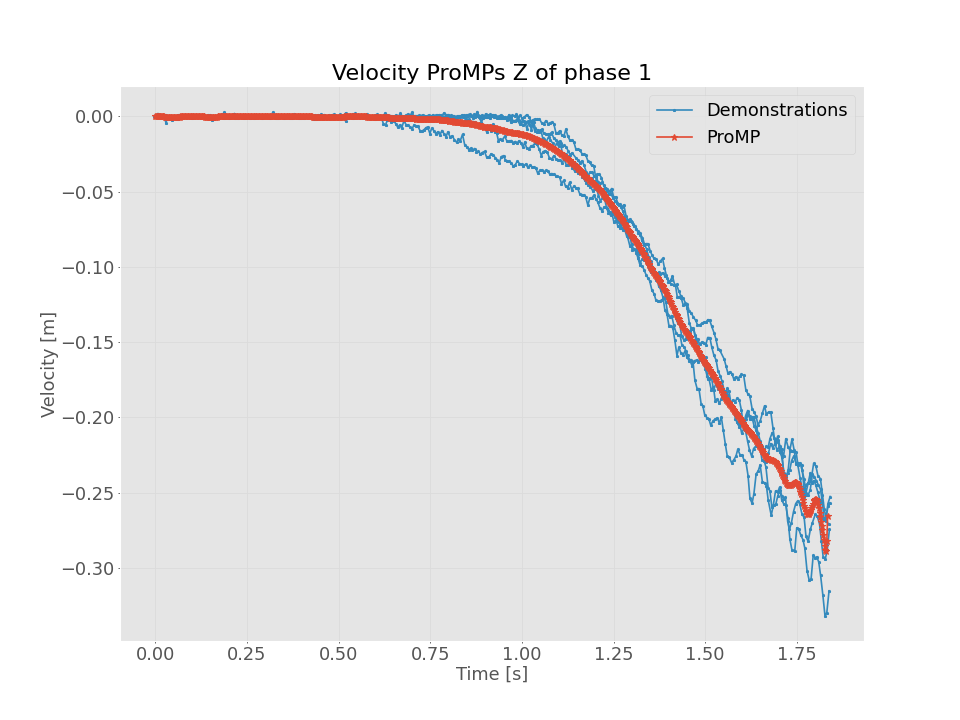

/home/sven/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


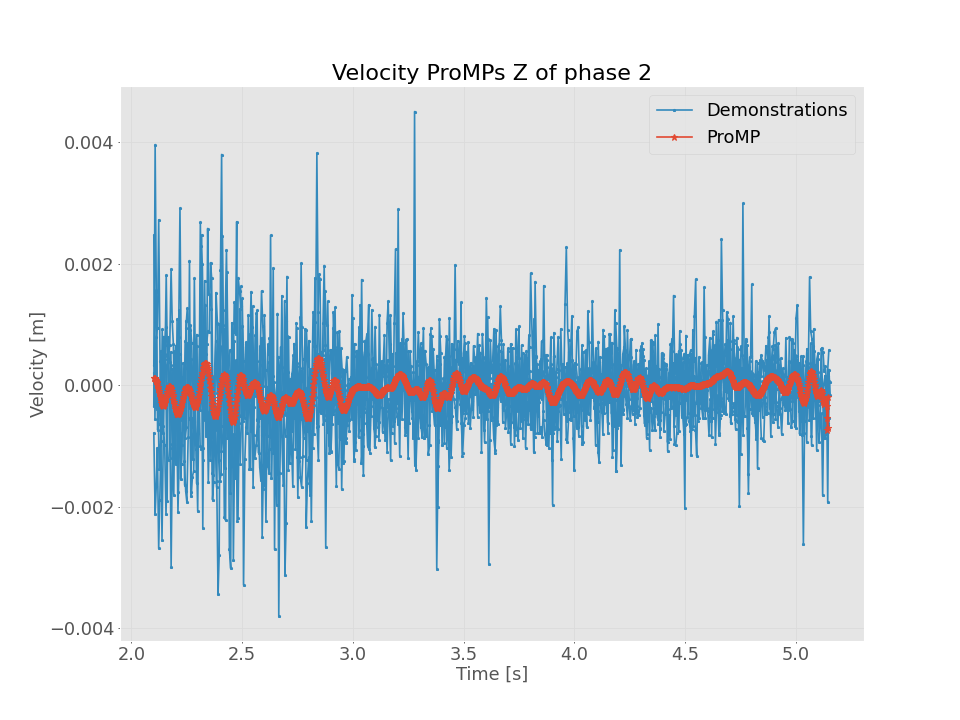

In [14]:
# Plot velocity data per phase
for j in range(3):
    for phase in range(len(position_evaluated_data)):
        plt.figure(figsize=config.figsize,dpi=config.dpi)
        plt.rcParams['xtick.labelsize'] = config.fontsize2
        plt.rcParams['ytick.labelsize'] = config.fontsize2
        
        for i in range(len(position_phase_data[phase])):
            data = velocity_phase_data[phase][i].get_index(j)
            plt.plot(data.time, data.value,'C1-*',linewidth=config.linewidth, markersize=config.markersize3,label=f'Demonstrations')
        
        data = velocity_evaluated_data[phase].get_index(j)
        plt.plot(data.time, data.value,'C0-*',linewidth=config.linewidth, markersize=config.markersize2,label='ProMP')
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
        plt.xlabel('Time [s]',fontsize=config.fontsize2)
        plt.ylabel('Velocity [m]',fontsize=config.fontsize2)
        plt.title(f'Velocity ProMPs {config.variable_labels[j]} of phase {phase+1}',fontsize=config.fontsize1)

<IPython.core.display.Javascript object>


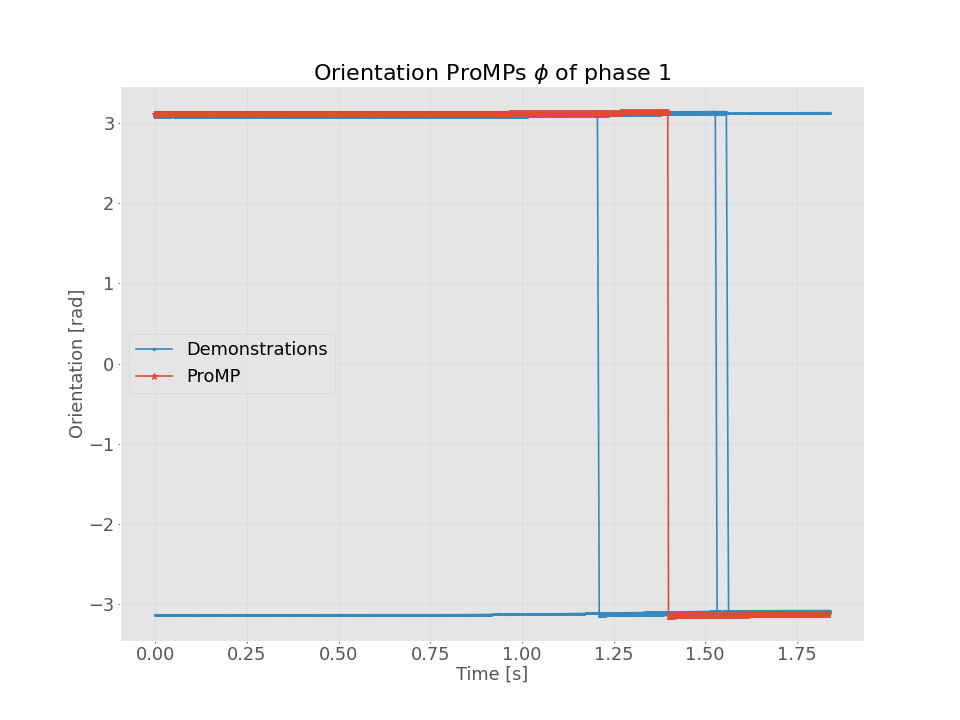

<IPython.core.display.Javascript object>


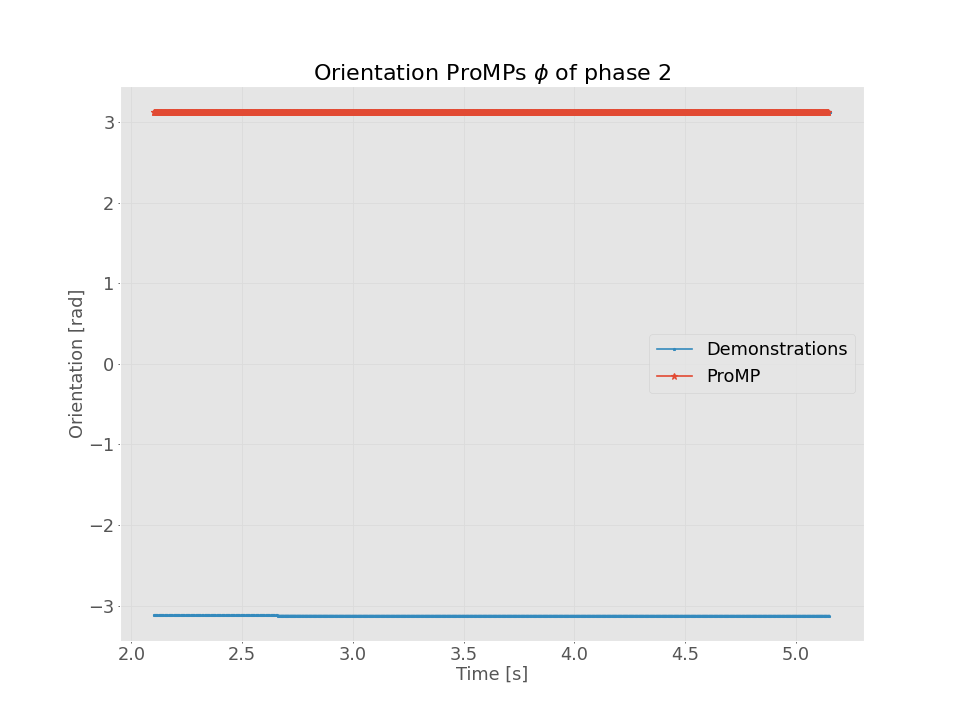

<IPython.core.display.Javascript object>


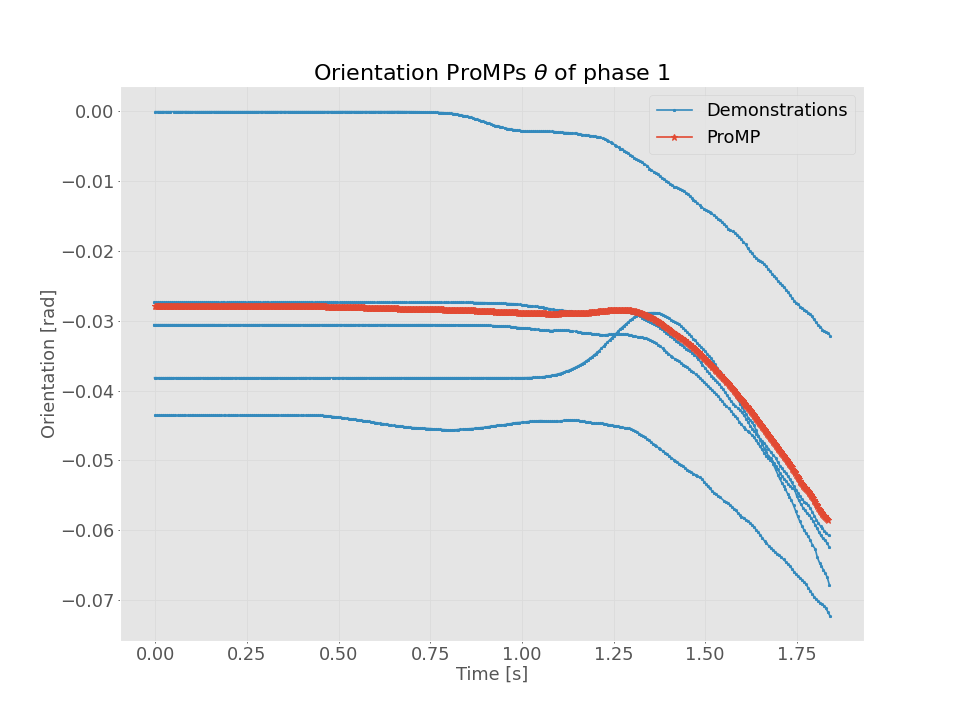

<IPython.core.display.Javascript object>


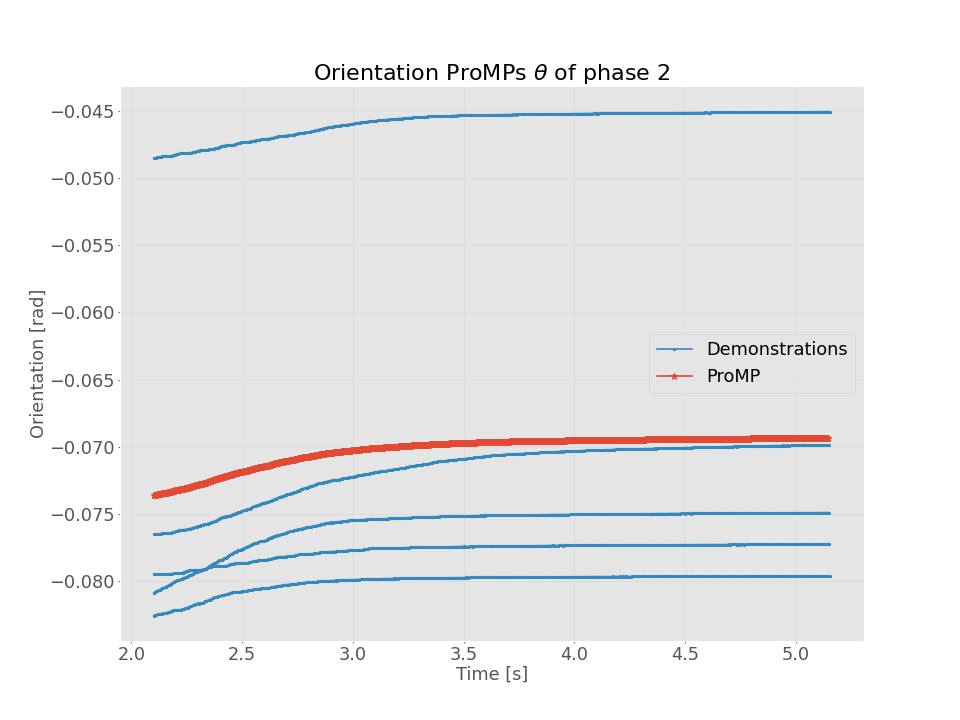

<IPython.core.display.Javascript object>


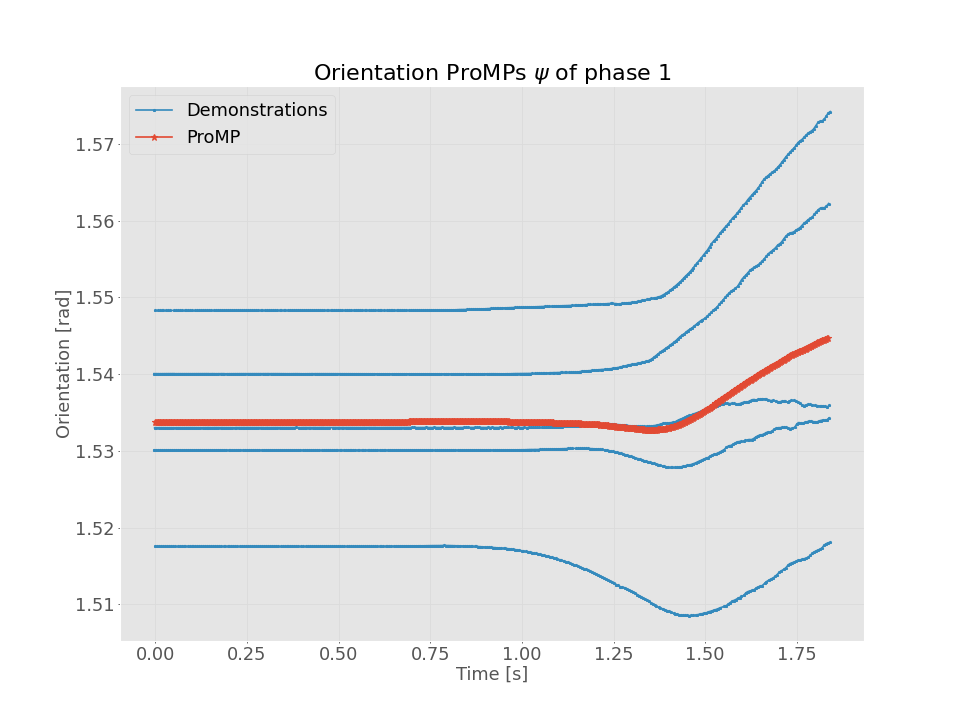

<IPython.core.display.Javascript object>


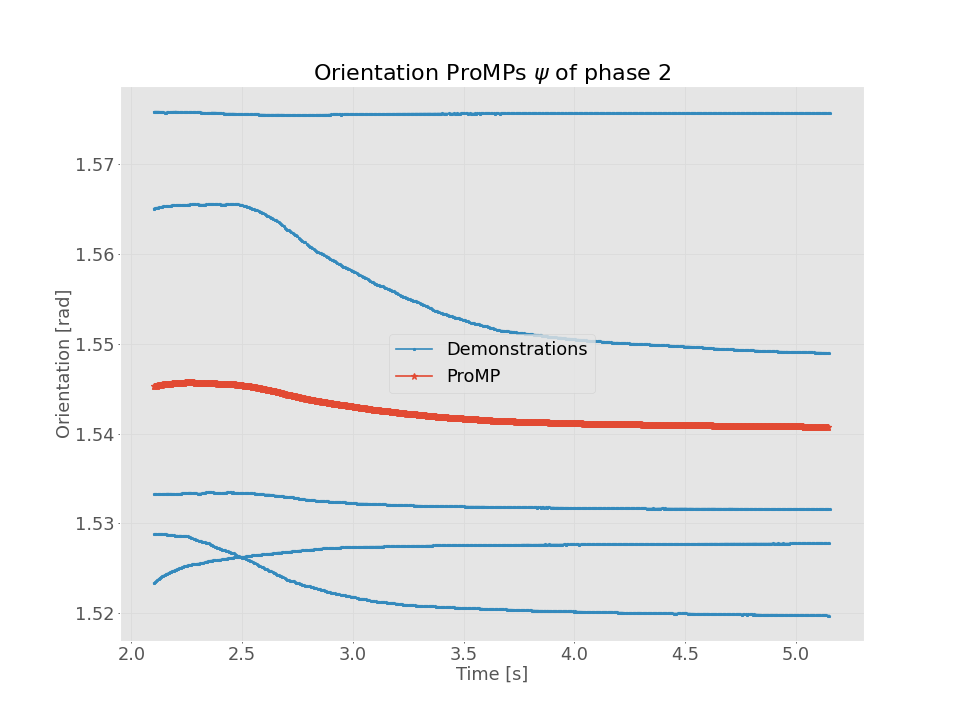

In [15]:
# Plot orientation data per phase
for j in range(3):
    for phase in range(len(orientation_evaluated_data)):
        plt.figure(figsize=config.figsize,dpi=config.dpi)
        plt.rcParams['xtick.labelsize'] = config.fontsize2
        plt.rcParams['ytick.labelsize'] = config.fontsize2
        
        for i in range(len(orientation_phase_data[phase])):
            data = orientation_phase_data[phase][i].get_index(j)
            plt.plot(data.time, data.value,'C1-*',linewidth=config.linewidth, markersize=config.markersize3,label=f'Demonstrations')
        
        data = orientation_evaluated_data[phase].get_index(j)
        plt.plot(data.time, data.value,'C0-*',linewidth=config.linewidth, markersize=config.markersize2,label='ProMP')
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
        plt.xlabel('Time [s]',fontsize=config.fontsize2)
        plt.ylabel('Orientation [rad]',fontsize=config.fontsize2)
        plt.title(f'Orientation ProMPs {config.variable_labels[j+3]} of phase {phase+1}',fontsize=config.fontsize1)